**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


**Loading and Exploring the Dataset**

In [2]:
data = pd.read_csv('Mall_Customers.csv')

print("\nDataset Overview:")
print(data.head())
print(f"\nShape: {data.shape}")
print(f"\nMissing Values:\n{data.isnull().sum()}")
print(f"\nData Types:\n{data.dtypes}")
print(f"\nBasic Statistics:\n{data.describe()}")



Dataset Overview:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Shape: (200, 5)

Missing Values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Data Types:
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Basic Statistics:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   10

**2D Segmentation: Annual Income vs Spending Score**

In [3]:
X_2d = data[['Annual Income (k$)', 'Spending Score (1-100)']].values
scaler_2d = StandardScaler()
X_2d_scaled = scaler_2d.fit_transform(X_2d)


**Finding Optimal Clusters (Elbow & Silhouette Method - 2D)**

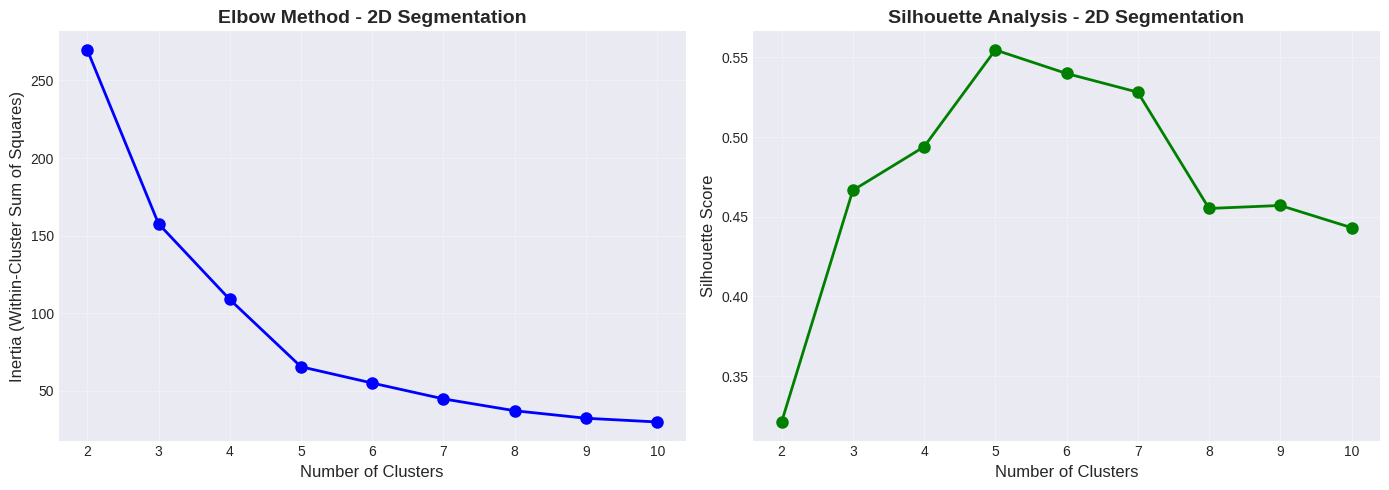


Optimal number of clusters (2D): 5


In [4]:
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_2d_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_2d_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method - 2D Segmentation', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis - 2D Segmentation', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k_2d = 5
print(f"\nOptimal number of clusters (2D): {optimal_k_2d}")


**K-Means and Hierarchical Clustering (2D)**

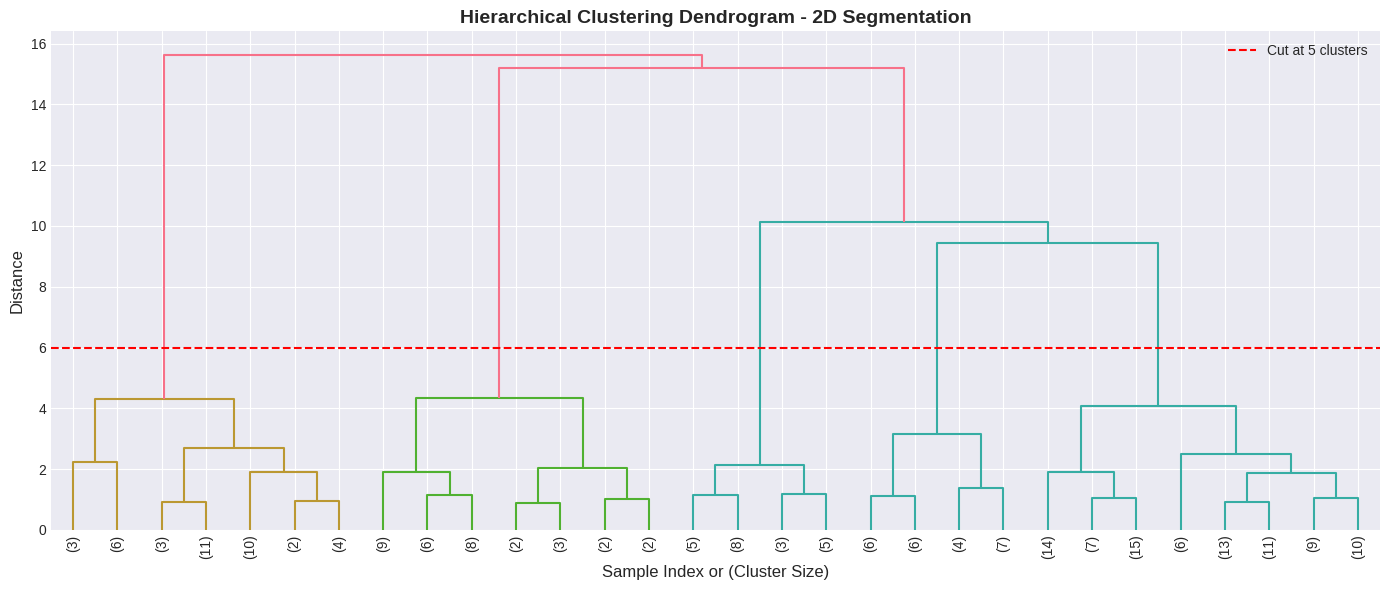

In [5]:
kmeans_2d = KMeans(n_clusters=optimal_k_2d, random_state=42, n_init=10)
data['Cluster_2D'] = kmeans_2d.fit_predict(X_2d_scaled)

linkage_matrix_2d = linkage(X_2d_scaled, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix_2d, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - 2D Segmentation', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=6, color='r', linestyle='--', label='Cut at 5 clusters')
plt.legend()
plt.tight_layout()
plt.show()

hierarchical_2d = AgglomerativeClustering(n_clusters=optimal_k_2d)
data['Cluster_2D_Hierarchical'] = hierarchical_2d.fit_predict(X_2d_scaled)


**Visualizing 2D Clusters**

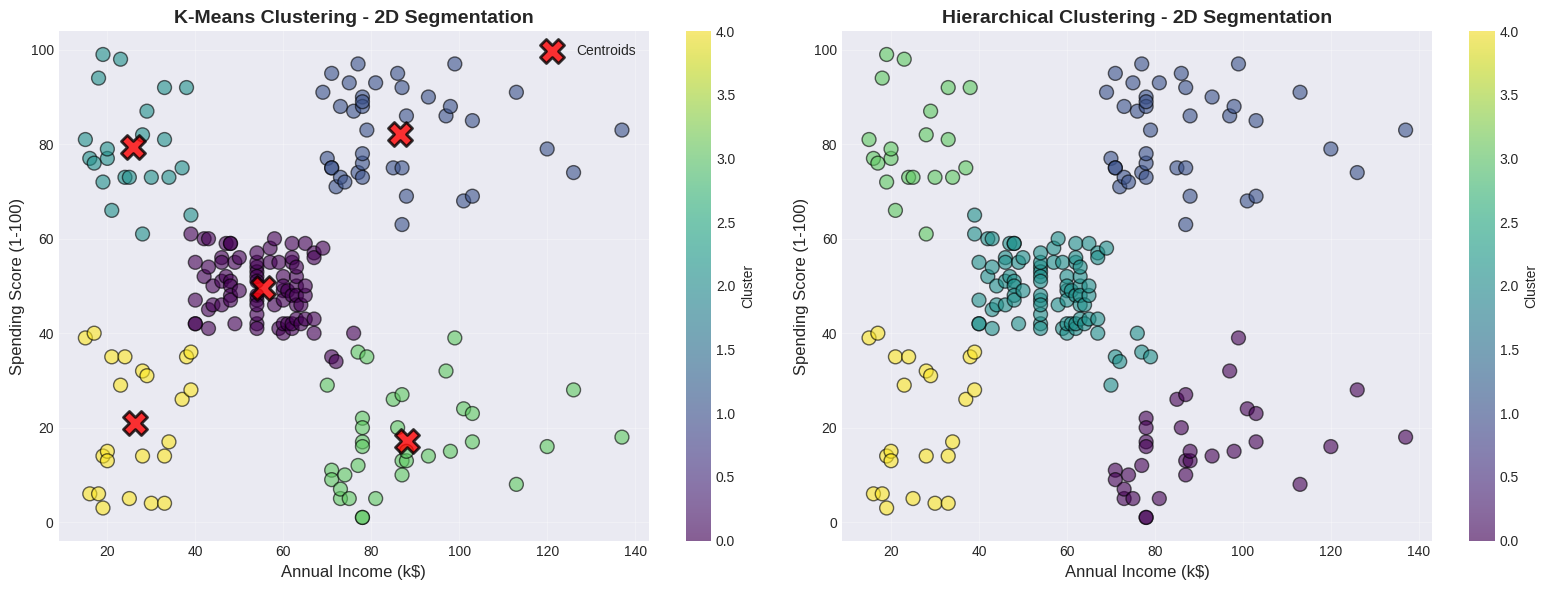

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
                           c=data['Cluster_2D'], cmap='viridis', s=100, alpha=0.6, edgecolors='black')
centers_2d = scaler_2d.inverse_transform(kmeans_2d.cluster_centers_)
axes[0].scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=300, alpha=0.8,
                edgecolors='black', linewidths=2, marker='X', label='Centroids')
axes[0].set_xlabel('Annual Income (k$)', fontsize=12)
axes[0].set_ylabel('Spending Score (1-100)', fontsize=12)
axes[0].set_title('K-Means Clustering - 2D Segmentation', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
                           c=data['Cluster_2D_Hierarchical'], cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[1].set_xlabel('Annual Income (k$)', fontsize=12)
axes[1].set_ylabel('Spending Score (1-100)', fontsize=12)
axes[1].set_title('Hierarchical Clustering - 2D Segmentation', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()


**Analyzing 2D Cluster Profiles**

In [7]:
cluster_means_2d = data.groupby('Cluster_2D')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
cluster_means_sorted_2d = cluster_means_2d.sort_values('Annual Income (k$)')

income_terciles = np.percentile(cluster_means_sorted_2d['Annual Income (k$)'], [33, 67])
spending_median = cluster_means_sorted_2d['Spending Score (1-100)'].median()

actual_segment_names_2d = {}
for cluster_id in cluster_means_sorted_2d.index:
    income = cluster_means_sorted_2d.loc[cluster_id, 'Annual Income (k$)']
    spending = cluster_means_sorted_2d.loc[cluster_id, 'Spending Score (1-100)']

    if income < income_terciles[0]:
        income_label = 'Low Income'
    elif income < income_terciles[1]:
        income_label = 'Medium Income'
    else:
        income_label = 'High Income'

    if spending < spending_median:
        spending_label = 'Low Spending'
    else:
        spending_label = 'High Spending'

    actual_segment_names_2d[cluster_id] = f"{income_label}, {spending_label}"

data['Segment_2D'] = data['Cluster_2D'].map(actual_segment_names_2d)


**2D Segment Summary**

In [8]:
print("2D SEGMENT PROFILES")

for cluster_id in sorted(data['Cluster_2D'].unique()):
    segment_data = data[data['Cluster_2D'] == cluster_id]
    print(f"\nSegment: {actual_segment_names_2d[cluster_id]} (Cluster {cluster_id})")
    print(f"  → Size: {len(segment_data)} customers ({len(segment_data)/len(data)*100:.1f}%)")
    print(f"  → Avg Age: {segment_data['Age'].mean():.1f} years")
    print(f"  → Avg Income: ${segment_data['Annual Income (k$)'].mean():.1f}k")
    print(f"  → Avg Spending Score: {segment_data['Spending Score (1-100)'].mean():.1f}")
    print(f"  → Gender Distribution: {segment_data['Gender'].value_counts().to_dict()}")


2D SEGMENT PROFILES

Segment: Medium Income, High Spending (Cluster 0)
  → Size: 81 customers (40.5%)
  → Avg Age: 42.7 years
  → Avg Income: $55.3k
  → Avg Spending Score: 49.5
  → Gender Distribution: {'Female': 48, 'Male': 33}

Segment: High Income, High Spending (Cluster 1)
  → Size: 39 customers (19.5%)
  → Avg Age: 32.7 years
  → Avg Income: $86.5k
  → Avg Spending Score: 82.1
  → Gender Distribution: {'Female': 21, 'Male': 18}

Segment: Low Income, High Spending (Cluster 2)
  → Size: 22 customers (11.0%)
  → Avg Age: 25.3 years
  → Avg Income: $25.7k
  → Avg Spending Score: 79.4
  → Gender Distribution: {'Female': 13, 'Male': 9}

Segment: High Income, Low Spending (Cluster 3)
  → Size: 35 customers (17.5%)
  → Avg Age: 41.1 years
  → Avg Income: $88.2k
  → Avg Spending Score: 17.1
  → Gender Distribution: {'Male': 19, 'Female': 16}

Segment: Low Income, Low Spending (Cluster 4)
  → Size: 23 customers (11.5%)
  → Avg Age: 45.2 years
  → Avg Income: $26.3k
  → Avg Spending Score: 

***3D Segmentation: Age, Income, and Spending Score***

In [9]:
X_3d = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values
scaler_3d = StandardScaler()
X_3d_scaled = scaler_3d.fit_transform(X_3d)


**Finding Optimal Clusters (3D)**

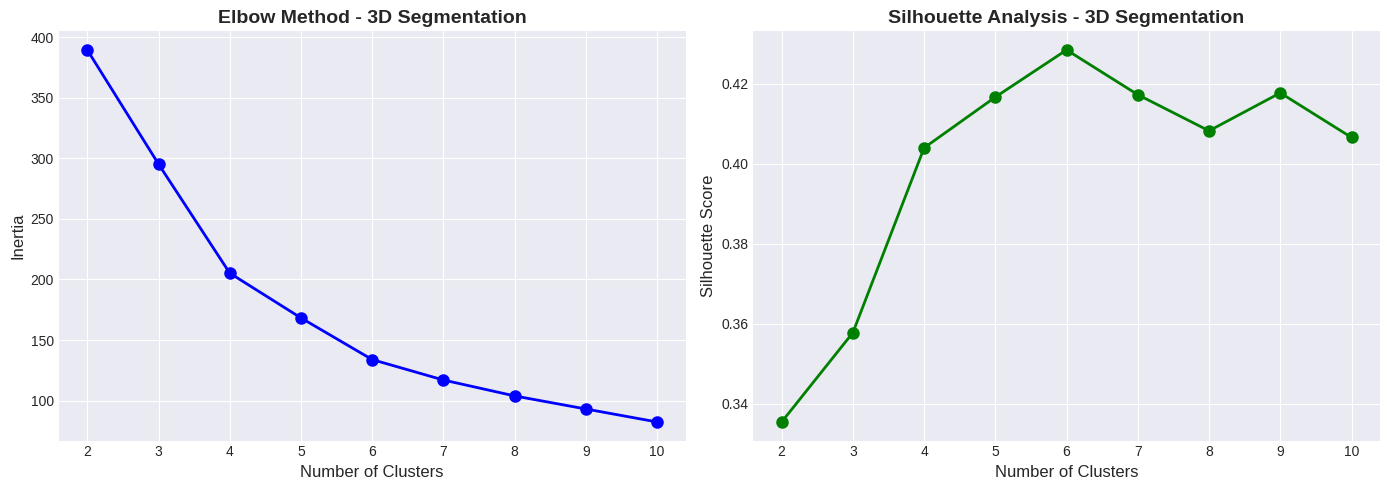


Optimal number of clusters (3D): 6


In [10]:
inertias_3d = []
silhouette_scores_3d = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_3d_scaled)
    inertias_3d.append(kmeans.inertia_)
    silhouette_scores_3d.append(silhouette_score(X_3d_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias_3d, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method - 3D Segmentation', fontsize=14, fontweight='bold')

axes[1].plot(K_range, silhouette_scores_3d, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis - 3D Segmentation', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

optimal_k_3d = 6
print(f"\nOptimal number of clusters (3D): {optimal_k_3d}")


**K-Means and Hierarchical Clustering (3D)**

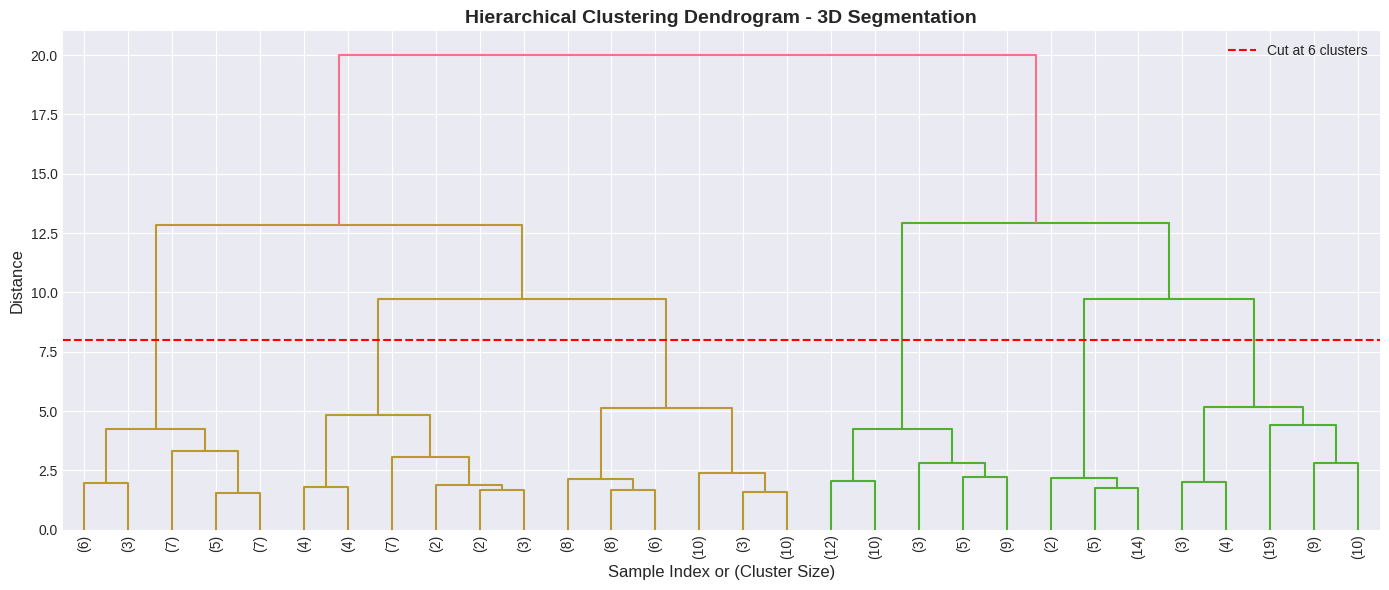

In [11]:
kmeans_3d = KMeans(n_clusters=optimal_k_3d, random_state=42, n_init=10)
data['Cluster_3D'] = kmeans_3d.fit_predict(X_3d_scaled)

linkage_matrix_3d = linkage(X_3d_scaled, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix_3d, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - 3D Segmentation', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=8, color='r', linestyle='--', label='Cut at 6 clusters')
plt.legend()
plt.tight_layout()
plt.show()

hierarchical_3d = AgglomerativeClustering(n_clusters=optimal_k_3d)
data['Cluster_3D_Hierarchical'] = hierarchical_3d.fit_predict(X_3d_scaled)


**Dimensionality Reduction with PCA**

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_3d_scaled)
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]

print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")



PCA Explained Variance Ratio: [0.44266167 0.33308378]
Total Variance Explained: 77.57%


**Visualizing 3D Clusters (PCA View)**

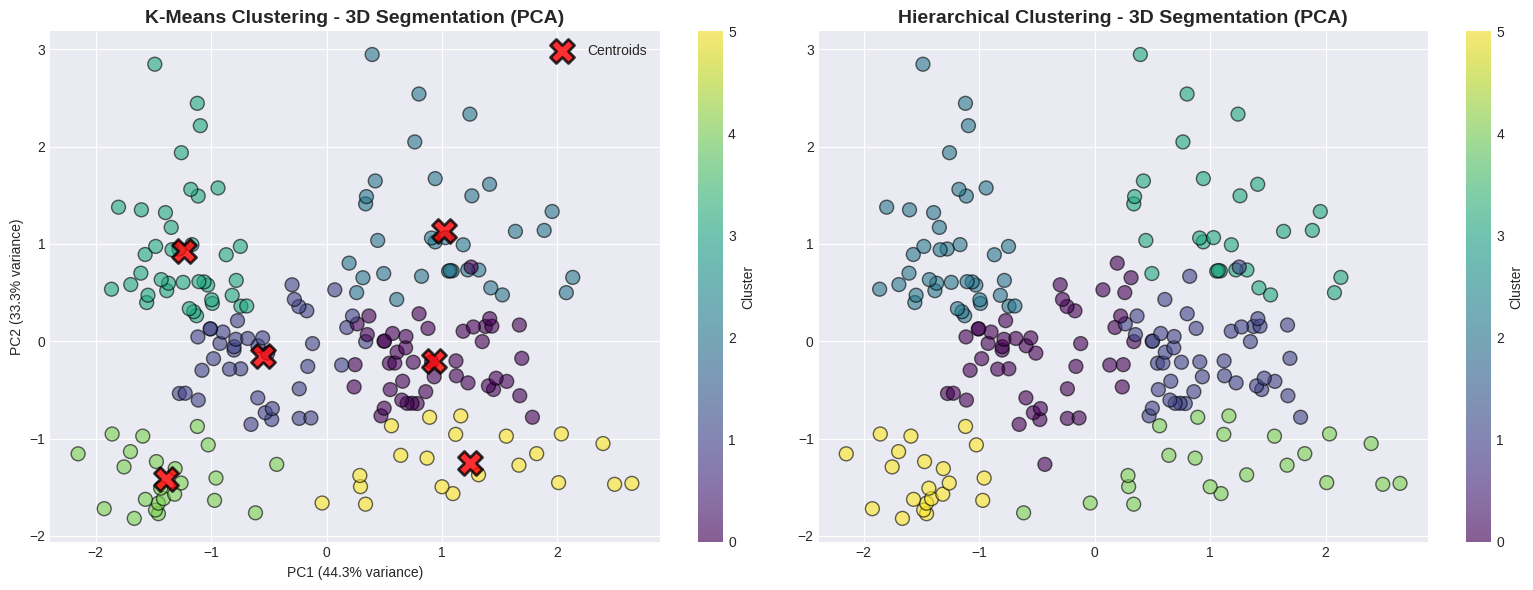

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(data['PCA1'], data['PCA2'], c=data['Cluster_3D'],
                           cmap='viridis', s=100, alpha=0.6, edgecolors='black')
centers_pca = pca.transform(kmeans_3d.cluster_centers_)
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=300, alpha=0.8,
                edgecolors='black', linewidths=2, marker='X', label='Centroids')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0].set_title('K-Means Clustering - 3D Segmentation (PCA)', fontsize=14, fontweight='bold')
axes[0].legend()
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(data['PCA1'], data['PCA2'], c=data['Cluster_3D_Hierarchical'],
                           cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[1].set_title('Hierarchical Clustering - 3D Segmentation (PCA)', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()


**Cluster Profiling and Segment Naming (3D)**

In [14]:
cluster_profiles_3d = data.groupby('Cluster_3D')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()

age_terciles = np.percentile(cluster_profiles_3d['Age'], [33, 67])
income_terciles_3d = np.percentile(cluster_profiles_3d['Annual Income (k$)'], [33, 67])
spending_terciles = np.percentile(cluster_profiles_3d['Spending Score (1-100)'], [33, 67])

segment_names_3d = {}
for cluster_id in cluster_profiles_3d.index:
    age = cluster_profiles_3d.loc[cluster_id, 'Age']
    income = cluster_profiles_3d.loc[cluster_id, 'Annual Income (k$)']
    spending = cluster_profiles_3d.loc[cluster_id, 'Spending Score (1-100)']

    if age < age_terciles[0]:
        age_label = 'Young'
    elif age < age_terciles[1]:
        age_label = 'Middle-Aged'
    else:
        age_label = 'Senior'

    if income < income_terciles_3d[0]:
        income_label = 'Budget'
    elif income < income_terciles_3d[1]:
        income_label = 'Standard'
    else:
        income_label = 'Premium'

    if spending < spending_terciles[0]:
        spending_label = 'Careful'
    elif spending < spending_terciles[1]:
        spending_label = 'Moderate'
    else:
        spending_label = 'Enthusiast'

    segment_names_3d[cluster_id] = f"{age_label} {income_label} {spending_label}s"

data['Segment_3D'] = data['Cluster_3D'].map(segment_names_3d)


**3D Segment Summary and Radar Visualization**


----------------------------------------------------------------------
3D SEGMENT PROFILES
----------------------------------------------------------------------

Senior Standard Moderates (Cluster 0)
  Size: 45 customers (22.5%)
  Avg Age: 56.3 years
  Avg Income: $54.3k
  Avg Spending Score: 49.1
  Gender Distribution: {'Female': 26, 'Male': 19}

Young Standard Moderates (Cluster 1)
  Size: 39 customers (19.5%)
  Avg Age: 26.8 years
  Avg Income: $57.1k
  Avg Spending Score: 48.1
  Gender Distribution: {'Female': 25, 'Male': 14}

Middle-Aged Premium Carefuls (Cluster 2)
  Size: 33 customers (16.5%)
  Avg Age: 41.9 years
  Avg Income: $88.9k
  Avg Spending Score: 17.0
  Gender Distribution: {'Male': 19, 'Female': 14}

Middle-Aged Premium Enthusiasts (Cluster 3)
  Size: 39 customers (19.5%)
  Avg Age: 32.7 years
  Avg Income: $86.5k
  Avg Spending Score: 82.1
  Gender Distribution: {'Female': 21, 'Male': 18}

Young Budget Enthusiasts (Cluster 4)
  Size: 23 customers (11.5%)
  Avg Age:

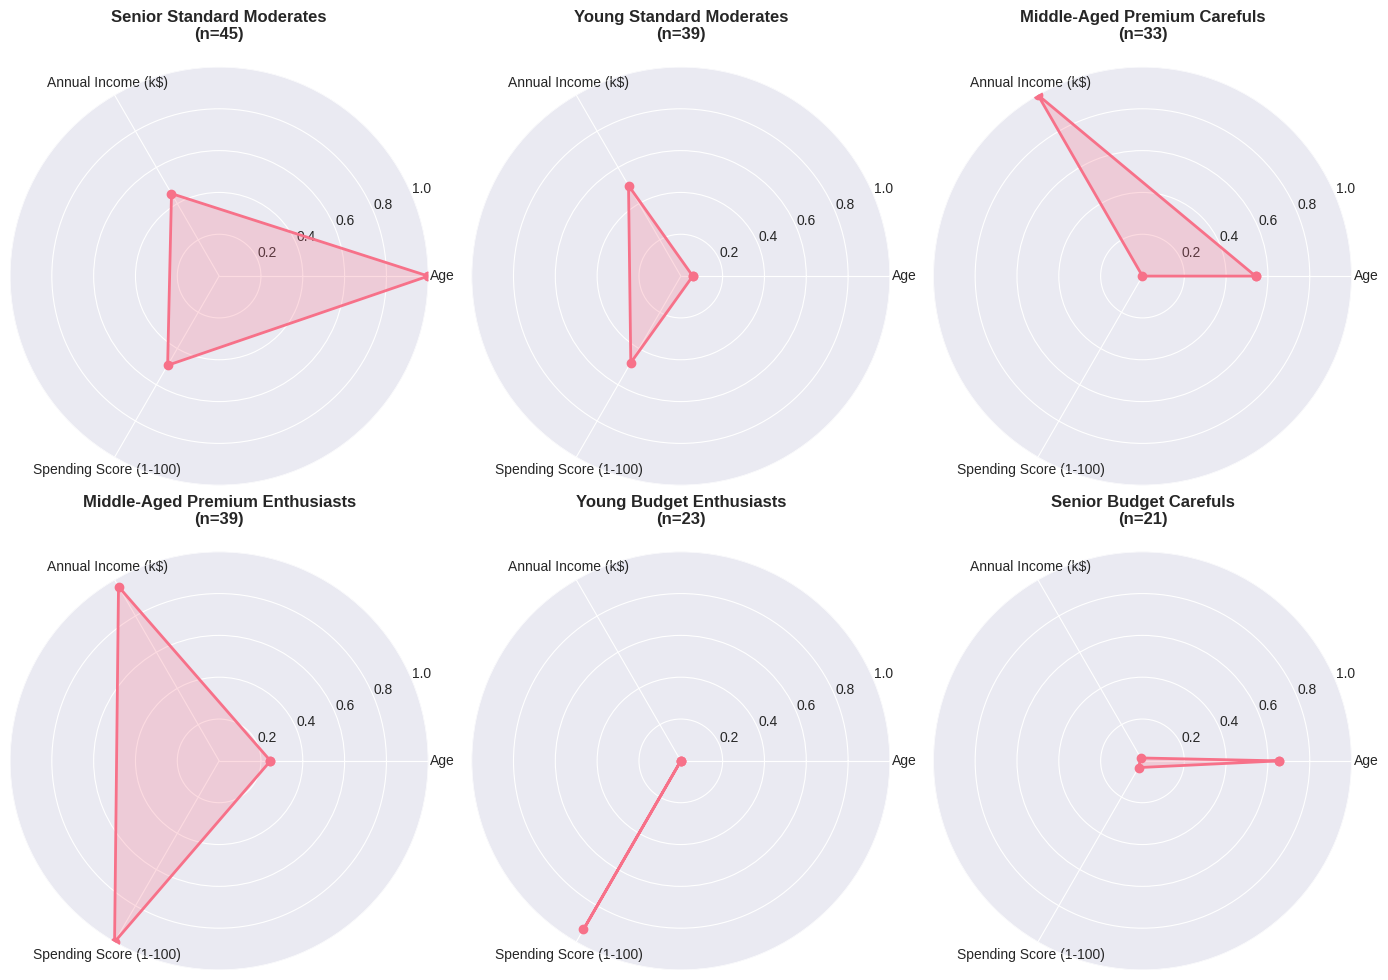

In [15]:
print("\n" + "-"*70)
print("3D SEGMENT PROFILES")
print("-"*70)

for cluster_id in sorted(data['Cluster_3D'].unique()):
    segment_data = data[data['Cluster_3D'] == cluster_id]
    print(f"\n{segment_names_3d[cluster_id]} (Cluster {cluster_id})")
    print(f"  Size: {len(segment_data)} customers ({len(segment_data)/len(data)*100:.1f}%)")
    print(f"  Avg Age: {segment_data['Age'].mean():.1f} years")
    print(f"  Avg Income: ${segment_data['Annual Income (k$)'].mean():.1f}k")
    print(f"  Avg Spending Score: {segment_data['Spending Score (1-100)'].mean():.1f}")
    print(f"  Gender Distribution: {segment_data['Gender'].value_counts().to_dict()}")

cluster_stats = data.groupby('Cluster_3D').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean'
})

normalized_stats = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min())
categories = list(normalized_stats.columns)

fig = plt.figure(figsize=(14, 10))
for idx, cluster_id in enumerate(normalized_stats.index):
    ax = fig.add_subplot(2, 3, idx + 1, projection='polar')
    values = normalized_stats.loc[cluster_id].values.tolist()
    values += values[:1]
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
    angles += angles[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=segment_names_3d[cluster_id])
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=10)
    ax.set_ylim(0, 1)
    ax.set_title(f"{segment_names_3d[cluster_id]}\n(n={len(data[data['Cluster_3D']==cluster_id])})",
                 size=12, fontweight='bold', pad=20)
    ax.grid(True)

plt.tight_layout()
plt.show()


**Final Summary and Recommendations**

In [16]:


summary_df = data.groupby('Segment_3D').agg({
    'CustomerID': 'count',
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean'
}).rename(columns={
    'CustomerID': 'Number of Customers',
    'Age': 'Avg Age',
    'Annual Income (k$)': 'Avg Income (k$)',
    'Spending Score (1-100)': 'Avg Spending Score'
})

print(summary_df)

print("\nRECOMMENDATIONS:")
print("- High Value Segment: Focus on retention with premium experiences.")
print("- Medium Value Segment: Offer loyalty incentives or upsell options.")
print("- Low Value Segment: Target with promotional offers or awareness campaigns.")


                                 Number of Customers    Avg Age  \
Segment_3D                                                        
Middle-Aged Premium Carefuls                      33  41.939394   
Middle-Aged Premium Enthusiasts                   39  32.692308   
Senior Budget Carefuls                            21  45.523810   
Senior Standard Moderates                         45  56.333333   
Young Budget Enthusiasts                          23  25.000000   
Young Standard Moderates                          39  26.794872   

                                 Avg Income (k$)  Avg Spending Score  
Segment_3D                                                            
Middle-Aged Premium Carefuls           88.939394           16.969697  
Middle-Aged Premium Enthusiasts        86.538462           82.128205  
Senior Budget Carefuls                 26.285714           19.380952  
Senior Standard Moderates              54.266667           49.066667  
Young Budget Enthusiasts             